In [64]:
import re
import numpy as np
import pandas as pd
from datetime import date
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from currency_converter import CurrencyConverter
c = CurrencyConverter()

### scrape international currency symbols & codes

In [65]:
import requests
from bs4 import BeautifulSoup

In [66]:
req = requests.get('https://www.xe.com/symbols.php')
soup = BeautifulSoup(req.content)

table = soup.find('table', {'class':'currencySymblTable'} )

rows = table.find_all('tr')
h_vals = [v.text for v in rows[0].find_all('td')]

data = []
for row in rows[1:]:
    r_data = {}
    for i, td in enumerate(row.find_all('td')):
        r_data[h_vals[i]] = td.text
    data.append(r_data)
    
data = pd.DataFrame(data)

data['country'] = data['Country and Currency'].apply(lambda x: ' '.join(x.split()[:-1]))
data['name'] = data['Country and Currency'].apply(lambda x: x.split()[-1])
data.rename(columns={'Font: Code2000':'symbol',
                     'Currency Code':'code'},
           inplace=True)
data = data[['name', 'country', 'code', 'symbol']]

#### fix a few missing symbols

In [67]:
data[data.symbol=='']

,name,country,code,symbol
44,Rupee,India,INR,
98,Lira,Turkey,TRY,


In [68]:
data.loc[44, 'symbol'] = '₹'
data.loc[98, 'symbol'] = '₺'
data[data.symbol=='']

,name,country,code,symbol


In [69]:
ref_data = data.copy()
ref_data.head()

,name,country,code,symbol
0,Lek,Albania,ALL,Lek
1,Afghani,Afghanistan,AFN,؋
2,Peso,Argentina,ARS,$
3,Guilder,Aruba,AWG,ƒ
4,Dollar,Australia,AUD,$


# parse currencies and amounts from main data 

In [70]:
# find cost number
def parse_num(cost):
    cost = re.findall('[\d]*', cost)
    if set(cost) != {''}:
        return int(''.join(cost))
    else:
        return '?'

# find payment period and currency if possible
def parse_cur(cost):
    parts = cost.replace(',','').split('/')
    
    if len(parts)-1:
        time = parts[-1].strip()
    else: time = '?'

    if len(re.findall('\d', parts[0])):
        cur = re.sub("[\d]*", "", parts[0]).strip()
    else: cur = '?'
        
    return time, cur

# apply both parsers above
def get_cost_info(df, visualize=False):
    df.rename(columns={k:k.lower() for k in df.columns}, inplace=True)
    df['cost_num'] = df['cost'].apply(parse_num)

    df['pay_per'], df['currency'] = zip(*df['cost'].map(parse_cur))
    
    if visualize:
        if df.pay_per.nunique()>1:
            print('Payment period options:')
            print('  ', df.pay_per.value_counts(), '\n')


        print('Currency distributions:')
        vcs = df.currency.value_counts()
        print(vcs) 
        plt.bar(vcs.index, vcs.values)
        plt.title('Distribution of cost currencies in data:')
        return 
    else: return df

# overview of currency distributions

Currency distributions:
$      508
?      102
€       25
R       10
HK$      4
₹        2
₪        1
Name: currency, dtype: int64


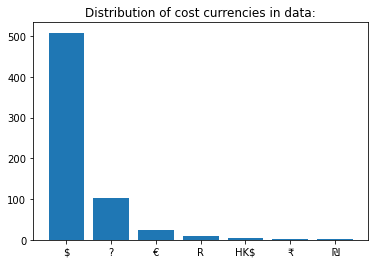

In [71]:
# BOOTCAMP DATA:
boot = pd.read_csv('boot_to_map.csv')
get_cost_info(boot, visualize=True)

Payment period options:
   year      1948
credit     319
?          140
full        27
module      26
Name: pay_per, dtype: int64 

Currency distributions:
EUR    2320
?       139
R         1
Name: currency, dtype: int64


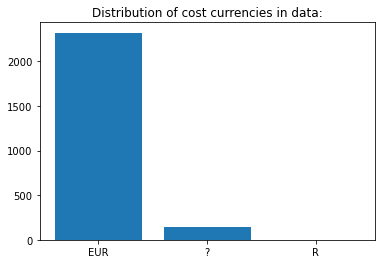

In [72]:
# UNIVERSITY DEGREE DATA:
uni = pd.read_csv('degs_to_map.csv')
get_cost_info(uni, visualize=True)

In [73]:
# overwrite data with cleaned currency features
boot = get_cost_info(boot)
uni = get_cost_info(uni)

---

# Search for matches in currency data

In [74]:
print('Reference data:')
data.sample(3)

Reference data:


,name,country,code,symbol
53,Won,Korea (North),KPW,₩
76,Sol,Peru,PEN,S/.
101,Pound,United Kingdom,GBP,£


In [75]:
print('Data to convert:')
uni[['location', 'cost', 'cost_num', 'pay_per', 'currency']].sample(3)

Data to convert:


,location,cost,cost_num,pay_per,currency
1200,"Stirling, Scotland, United Kingdom","17,605 EUR / year",17605,year,EUR
2404,"Porto, Portugal","1,880 EUR / year",1880,year,EUR
51,"Brighton, England, United Kingdom","16,074 EUR / year",16074,year,EUR


In [76]:
print('Data to convert:')
boot[['location', 'cost', 'cost_num', 'pay_per', 'currency']].sample(3)

Data to convert:


,location,cost,cost_num,pay_per,currency
323,Wilmington,"$2,200",2200,?,$
126,Boulder,"$7,000",7000,?,$
153,St. Louis,"$18,500",18500,?,$


#### search...

In [77]:
def convert_df(df):
    by = []

    print(f'Converting', len(df[df.currency!='$']), 'cost values...')
    for target_idx in df.index:
        trow = df.loc[target_idx]

        if '?' in str(trow['cost_num']) :
            converted = '?'# <- DO UNKNOWN & BREAK 
            
        elif 'HK' in trow['currency']:
            pass # need to deal with HONG KONG **

        elif '$' in trow['currency']: # PROBABLY USA
            converted = trow['cost_num']

        else: # NOT ALREADY IN USD (NEED TO CONVERT)

            for ref_idx in ref_data.index: # search all possible connection points
                ref_row = ref_data.loc[ref_idx]

                if ref_row['code'].strip()==trow['currency'].strip():
                    by += ['currency_code']
                    break
                elif trow['currency'].strip()==ref_row['symbol']:
                    by += ['currency_symbol']
                    break
                elif ref_row['country'] in trow['location'] and 'Bogotá' not in trow['location']:
                    by += ['location']
                    break
            if 'Barbados' in trow['location']: converted = trow['cost_num']/2

            else:
                converted = c.convert(trow['cost_num'], ref_row['code'], 'USD', date=date(2019, 12, 9))

        df.loc[target_idx, 'USD_cost'] = converted

    print('\rDone.', end=' '*50+'\n')
    return df # , by

In [78]:
# this takes about 30 seconds on my machine

In [79]:
for df in [uni, boot]:
    df = convert_df(df)

Converting 2460 cost values...
Done.                                                  
Converting 144 cost values...
Done.                                                  


### format USD cost features

In [80]:
for df in [uni, boot]:
    df['USD_cost_num'] = df['USD_cost'].copy()
    df['USD_cost'] = df['USD_cost'].apply(lambda x: "${:,}".format(int(x)) if x!='?' else x)
    df['cost'] = df['USD_cost'].astype(str)+df['pay_per'].apply(lambda x: f' / {x}' if x!='?' else '').astype(str)

## drop false positives (non-DS programs)

In [81]:
def smart_drop(df):
    dropped = 0
    kwords = ['data', 'stat', 'analy', 'busin', 'python'
          'intell', 'informat', 'fintech', 'cybersecur',
          'machine learn', 'machine-learn', 'optimiz',
          'geosp', 'ter sci', 'guage proc', 'african']

    for idx in df.index:
        title = d = str(df.loc[idx, 'course_name']).lower()
        
        if 'topics' in list(df.columns):
            desc = str(df.loc[idx, 'topics'])
        else:
            desc = str(df.loc[idx, 'description'])
        
        
        if any(k in title.lower() for k in kwords):
            keep = True
        elif any(k in desc.lower() for k in kwords):
            keep = True
        else: keep = False
        
        if not keep:
            df.drop(idx, inplace=True)
            dropped+=1
            
    print(f'Dropped {dropped} suspected false positives.')
    return df

In [82]:
uni = smart_drop(uni)

Dropped 54 suspected false positives.


In [83]:
boot = smart_drop(boot)

Dropped 0 suspected false positives.


In [84]:
uni

,course_name,institution,location,description,cost,dur_period,dur_number,class,degree,enrollment,...,coord,latitude,longitude,duration,pretty_degree,cost_num,pay_per,currency,USD_cost,USD_cost_num
0,"Business Administration, Concentration in Mana...",San José State University,"San Jose, California, United States","Business Administration, Concentration in Mana...","$5,496 / year",month,48.0,Bachelor's,B.Sc.,(?),...,"(37.3351874, -121.8810715)",37.335187,-121.881072,4 years,<b>Bachelor's (B.Sc.)</b> | In Person,4963,year,EUR,"$5,496",5496.52
1,Information Engineering,Hamburg University of Applied Sciences,"Hamburg, Germany",Today‘s complex information processing systems...,$0 / year,month,36.0,Bachelor's,B.Sc.,(?),...,"(53.5560114, 10.0227163)",53.556011,10.022716,3 years,<b>Bachelor's (B.Sc.)</b> | In Person,0,year,EUR,$0,0
2,Health Care Informatics,University of Illinois Springfield,"Springfield, Illinois, United States",The Health Care Informatics bachelor’s degree ...,"$29,278 / year",month,48.0,Bachelor's,B.Sc.,(?),...,"(39.7301376, -89.61852689999999)",39.730138,-89.618527,4 years,<b>Bachelor's (B.Sc.)</b> | In Person,26437,year,EUR,"$29,278",29279
3,Information Systems Technology - Information S...,Regent University,Online,The Bachelor of Science in Information Systems...,$549 / credit,month,48.0,Bachelor's,B.Sc.,(?),...,"(36.7993593, -76.1925395)",36.799359,-76.192539,4 years,<b>Bachelor's (B.Sc.)</b> | In Person,496,credit,EUR,$549,549.32
4,Mathematics Operational Research and Statistics,Cardiff University,"Cardiff, Wales, United Kingdom",Combine statistics and operational research wi...,"$26,757 / year",month,36.0,Bachelor's,B.Sc.,(?),...,"(51.48662710000001, -3.1788641)",51.486627,-3.178864,3 years,<b>Bachelor's (B.Sc.)</b> | In Person,24160,year,EUR,"$26,757",26757.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,African Master’s in Machine Intelligence,African Institute for Mathematical Sciences,"Biriwa, Ghana",NaN,?,NaN,NaN,Master's,NaN,Full-time,...,NaN,5.168048,-1.144657,1 year,<b>Full-time Master's (AMMI)</b> | In Person &...,?,?,?,?,?
2456,African Master’s in Machine Intelligence,African Institute for Mathematical Sciences,"MBour, Sénégal",NaN,?,NaN,NaN,Master's,NaN,Full-time,...,NaN,14.392066,-16.958084,1 year,<b>Full-time Master's (AMMI)</b> | In Person &...,?,?,?,?,?
2457,African Master’s in Machine Intelligence,African Institute for Mathematical Sciences,"Muizenberg, South Africa",NaN,?,NaN,NaN,Master's,NaN,Full-time,...,NaN,-34.107178,18.470513,1 year,<b>Full-time Master's (AMMI)</b> | In Person &...,?,?,?,?,?
2458,African Master’s in Machine Intelligence,African Institute for Mathematical Sciences,"Bagamoyo, Tanzania",NaN,?,NaN,NaN,Master's,NaN,Full-time,...,NaN,-6.445638,38.898731,1 year,<b>Full-time Master's (AMMI)</b> | In Person &...,?,?,?,?,?


In [85]:
boot.to_csv('boot_standardized.csv', index=False)
uni.to_csv('uni_standardized.csv', index=False)